In [1]:
%load_ext autoreload
%autoreload 2

import sys  
# Change this path to wherever you clone the repository to + /functions
sys.path.insert(0, '/home/ryan/ml_analysis/functions')
from plotting import *
from data_functions import *
import pandas as pd
import numpy as np
import compress_pickle as pickle  
import mplhep as hep
hep.style.use("CMS")
from matplotlib.backends.backend_pdf import PdfPages

/home/ryan/.local/lib/python3.8/site-packages/awkward0/__init__.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(numpy.__version__) < distutils.version.LooseVersion("1.13.1"):
2024-05-07 10:34:37.766145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 10:34:38.458532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Using variable strings ['E', 'X', 'Y', 'Z'] from binning_utils.py



## Saved Models 

## Saved Models for different configuration

In [2]:
conditions = {
    # Model used for single neutron studies
    ('zdc', 'neutron', 'graphnet', '4D', '2D', '64Fe', 'h4', False, '.5', '.5'):{
    'result_dir': '/home/ryan/zdc_studies/results/results_4D_output2D_zdc_h4_neutron_graphnet_correctdynamicrange/ECCE_20240129-1333_graphnet_4D/',
    'preprocessed_dir': 'preprocessed_input4D_output2D_zdc_h4_neutron_graphnet_energy0.5_theta0.5_correctdynamicrange',
    'discrete_data':'/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/',
    'num_discrete_files' : 50,  
    'continuous_data': '/media/miguel/Elements/zdc_data/zdc_neutron_log10continuous_10GeV-300GeV_0.0deg-0.3deg_staggered_h4_01_26_2024/', 
    'num_continuous_files':  150,
    },
    # Model used for multiple neutron studies
    ('zdc', 'neutron', 'graphnet', '4D', '1D', '64Fe', 'h4', False, None, None):{
    'result_dir': '/home/ryan/results_4D_output1D_zdc_h4_neutron_graphnet_energy_1to10_continuous+gaussian/ZDC_20240416-2223_graphnet_4D/',
    'preprocessed_dir': '/media/miguel/Expansion/preprocessed_input4D_output1D_zdc_h4_neutron_graphnet_1to10_continuous+gaussian/',
    'single_discrete_data':'/media/miguel/Elements/zdc_data/zdc_neutron_log10discrete_10GeV-1000GeV_0.0deg-0.3deg_staggered_h4_03_18_2024/',
    'multiparticle_discrete_data':'/media/miguel/Elements/zdc_data/zdc_neutron_1to10_fixed_100GeV-100GeV_0.0deg-0.23deg_staggered_h4_04_22_2024/',
    'num_discrete_files' : 100,  
    'continuous_data': '/media/miguel/Elements/zdc_data/zdc_neutron_1to10_training/', 
    'num_continuous_files':  200, 
    }
}

default_entry = {
    'result_dir': 'No_File',
    'preprocessed_dir': 'No_Title',
}


## PICK the Right models

In [3]:
detector='zdc'   ## insert, hcal, zdc, 
particle ='neutron'  # pi+,  pi0, neutron, gamma
model='graphnet'  ## graphnet, DeepSets
input_features='4D'  ## input features [4D, 2D, 1D]
output_dim='1D'    ## '1D' or '2D'
absorber='64Fe' ## Depends on detector
readout='h4' ## None for hcal , insert But for ZDC: h4, h3, unstaggered
include_ecal=False ## False (ZDC it should be False rest True uncless only HCAL data is taken)
energy_weight=None ## 'None' if no energy weight, 'energy_weight' otherwise
theta_weight=None ## 'None' if no theta weight, 'theta_weight' otherwise
classification=False

multiple_neutrons = True

save_plots = False

entry = conditions.get((detector, particle, model, input_features, output_dim, absorber, readout, include_ecal, energy_weight, theta_weight), default_entry)
path_to_result = entry['result_dir']
path_to_stat = entry['preprocessed_dir']

if entry['result_dir'] == 'No_File':
    print('File not found')    

print(path_to_result)  

/home/ryan/results_4D_output1D_zdc_h4_neutron_graphnet_energy_1to10_continuous+gaussian/ZDC_20240416-2223_graphnet_4D/


## Get predicted and target variable

In [4]:
if multiple_neutrons:
    npz_unpacked = np.load(path_to_result+"/predictions_appended_test_multiparticle.npz") 
else:
    npz_unpacked = np.load(path_to_result+"/predictions_appended_test_singleparticle.npz") 
predictions_2 = npz_unpacked['outputs_scaled']
targets_2 = npz_unpacked['targets_scaled']
targets = npz_unpacked['targets']
predictions = npz_unpacked['outputs']

if output_dim=='2D':
    targets_ene = targets_2[:,0]
    targets_theta= targets_2[:,1]

    predictions_ene=predictions_2[:,0]
    predictions_theta=predictions_2[:,1]
    
elif output_dim=='1D':
    targets_ene = targets_2
    predictions_ene=predictions_2
if classification:
    targets_particle = targets[:,-1]
    predictions_particle = predictions[:,-1]

# Obtaining the file names and event numbers for each entry
meta_info_initial = npz_unpacked['meta']
meta_info =[]
# The saved meta is in the form of [file_name, event_num, file_name, event_num, ...]
# Put it in the form [(file_name, event_num), (file_name, event_num), ...]
# This aligns its length with the lengths of targets and predictions
for i, element in enumerate(meta_info_initial):
    if i%2 == 0:
        file_name = meta_info_initial[i]
        event_num = int(meta_info_initial[i+1])
        meta_tuple = (file_name, event_num) # putting the file names and event numbers into a tuple
        meta_info.append(meta_tuple)
    else:
        continue
meta_info = np.asarray(meta_info, dtype='object,int') # Data type for each entry is (string, int), i.e. (object, int)


## Inspect the Loss curve

(100, 1463)


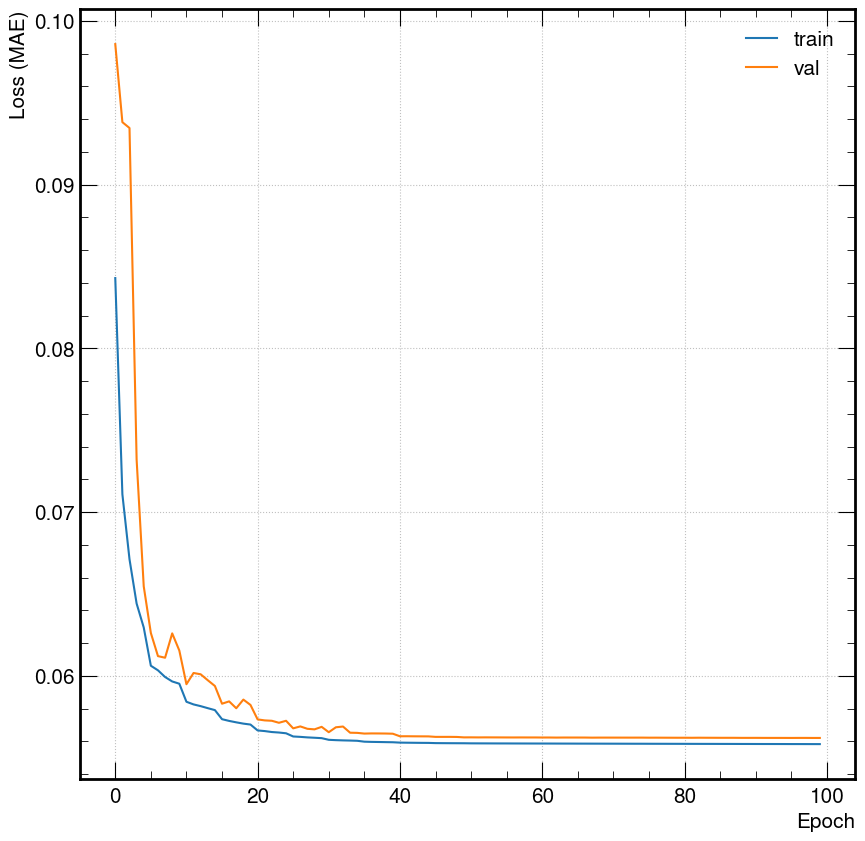

In [5]:
npz_unpacked_loss = np.load(path_to_result + "/losses.npz")

train_loss = npz_unpacked_loss['training']
val_loss = npz_unpacked_loss['validation']
print(val_loss.shape)
val_mean_loss=np.mean(val_loss, axis=1)
train_mean_loss=np.mean(train_loss, axis=1)

plt.plot(train_mean_loss,label='train')

plt.plot(val_mean_loss, label='val')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Loss (MAE)", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim(0.141,0.249)
plt.legend(fontsize=15)
plt.grid()

In [6]:
# Getting energy bins based off target energies
print(targets_ene)
energy_bins = np.unique(np.round(targets_ene).astype(int)) # Returns a sorted array of unique target energies
print(energy_bins)

[699.99725 499.99597 899.996   ... 199.99953 799.99475 199.99919]
[ 100  200  300  400  500  600  700  800  900 1000]


In [7]:
# Function that prints an np.array that is rounded and has commas separating the elements
# Takes lists and numpy arrays
def print_list(input_list):
    output = np.asarray(input_list)
    np.set_printoptions(precision=6)
    print(repr(output))

## Extract the Fit parameters 
* Energy Resolution is sigma/mean of E_{Pred}/E_{Truth} Distribution as function of Energy
* Theta Resolution is the  sigma of $ \Theta_{pred) $  - $\Theta_{Truth} distribution as function of energy

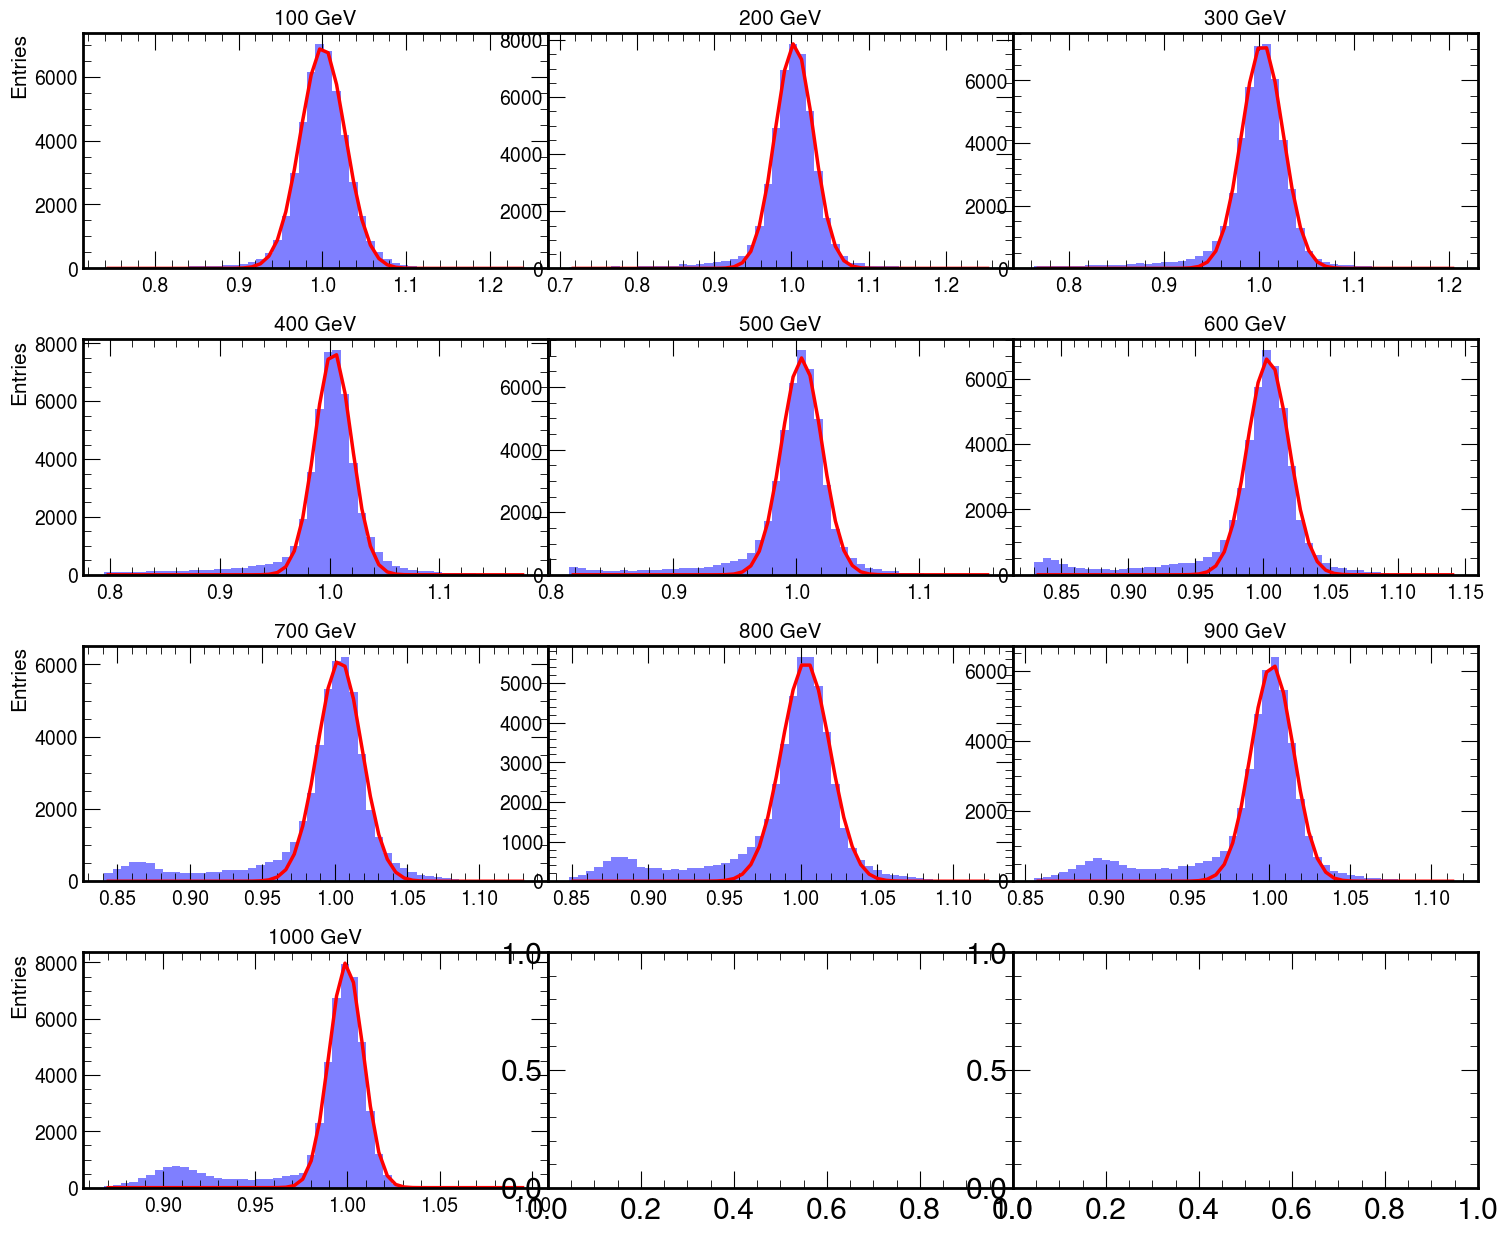

In [8]:
nbins=50
data_type='discrete'
particle='neutron'
fit_dist=True
data_type='discrete'
resolution_fit, pred_over_truth_fit, true_fit,slices_fit,slices_pred_truth =get_res_scale_fit_log10_log2\
(targets_ene,predictions_ene, energy_bins, nbins, data_type, particle, 'energy', fit=True, plot_range=3)

if output_dim=='2D':
    theta_pred_true_over_true=(predictions_theta - targets_theta)  
    resolution_fit_th, pred_over_truth_fit_th, true_fit_th,slices_fit_th,slices_pred_truth_th =get_res_scale_fit_log10_log2\
    (targets_ene, theta_pred_true_over_true, energy_bins, nbins, data_type, particle, 'theta-energy', fit=True, plot_range=3)

### Making the plots for the multiple neutron studies
#### Opens all the discrete data for multiple neutrons to get strawman performance
#### Reads multiple nuetron model to get GNN performance
#### Plots reconstructed energies and some shower shapes

In [9]:
if multiple_neutrons:
    directory = entry['multiparticle_discrete_data']
    num_files = 100
    zdc_sampling_fraction = .021
    zdc_MIP = 0.0006
    root_files_total = glob.glob(directory+'*root')
    file_list=root_files_total[0:num_files]

    strawman_reco_energies = []
    strawman_true_energies = []
    for i_file, file in enumerate(file_list):
        print("File ", i_file)
        with uproot.open(file+':events') as events:
            zdc_MC = events.arrays(["MCParticles.generatorStatus", "MCParticles.PDG", 'MCParticles.momentum.x', 'MCParticles.momentum.y', 'MCParticles.momentum.z', 'MCParticles.mass'])
            zdc_reco = events.arrays(["ZDCHcalHitsReco.energy", "ZDCHcalHitsReco.time"])
            zdc_energies = zdc_reco["ZDCHcalHitsReco.energy"]
            zdc_time = zdc_reco["ZDCHcalHitsReco.time"]
        MIP_condition = zdc_energies > zdc_MIP
        time_condition = zdc_time < 275
        zdc_energies = zdc_energies[MIP_condition & time_condition]
        event_energies = ak.sum(zdc_energies, axis = -1)
        event_energies = ak.to_numpy(event_energies)
        reconstructed_energy = np.divide(event_energies, zdc_sampling_fraction)
        strawman_reco_energies.append(reconstructed_energy)

        incident_mask = zdc_MC['MCParticles.generatorStatus']==1
        gen_px_particle = zdc_MC['MCParticles.momentum.x'][incident_mask]
        gen_py_particle = zdc_MC['MCParticles.momentum.y'][incident_mask]
        gen_pz_particle = zdc_MC['MCParticles.momentum.z'][incident_mask]
        gen_mass_particle = zdc_MC['MCParticles.mass'][incident_mask]
        gen_mom_particle = np.sqrt(gen_px_particle**2 + gen_py_particle**2 + gen_pz_particle**2)
        gen_energy_particle = np.sqrt(gen_mom_particle**2 + gen_mass_particle**2)
        gen_energy_total = ak.sum(gen_energy_particle, axis = 1)
        strawman_true_energies.append(gen_energy_total)

File  0
File  1
File  2
File  3
File  4
File  5
File  6
File  7
File  8
File  9
File  10
File  11
File  12
File  13
File  14
File  15
File  16
File  17
File  18
File  19
File  20
File  21
File  22
File  23
File  24
File  25
File  26
File  27
File  28
File  29
File  30
File  31
File  32
File  33
File  34
File  35
File  36
File  37
File  38
File  39
File  40
File  41
File  42
File  43
File  44
File  45
File  46
File  47
File  48
File  49
File  50
File  51
File  52
File  53
File  54
File  55
File  56
File  57
File  58
File  59
File  60
File  61
File  62
File  63
File  64
File  65
File  66
File  67
File  68
File  69
File  70
File  71
File  72
File  73
File  74
File  75
File  76
File  77
File  78
File  79
File  80
File  81
File  82
File  83
File  84
File  85
File  86
File  87
File  88
File  89
File  90
File  91
File  92
File  93
File  94
File  95
File  96
File  97
File  98
File  99


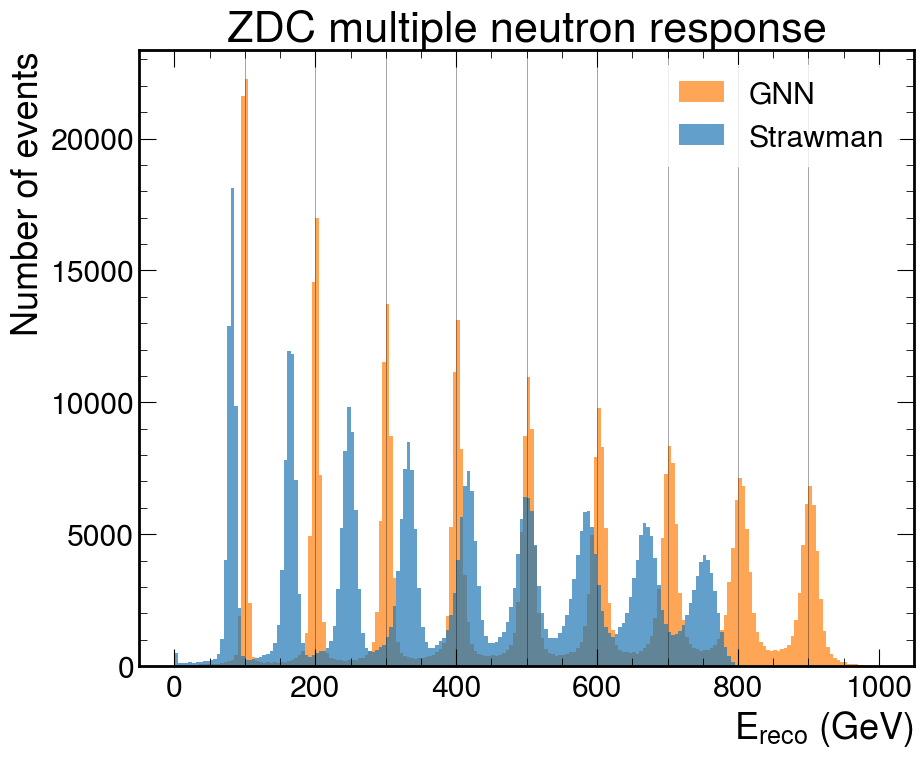

In [20]:
if multiple_neutrons:
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['savefig.bbox']='tight'
    plt.rcParams['legend.frameon']=True
    plt.rcParams['legend.edgecolor']='white'
    plt.rcParams["figure.figsize"] = (10, 8)

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Only looking at 9 neutrons or less
    ml_energy_mask = np.round(targets_ene).astype(int) < 1000

    strawman_np_energies = np.asarray(ak.flatten(strawman_true_energies))
    strawman_energy_mask = np.round(strawman_np_energies).astype(int) < 1000
    fig = plt.figure()
    plt.hist(predictions_ene[ml_energy_mask],
             200,
             range=[0, 1000],
             alpha = 0.7,
             label="GNN",
             color=colors[1],
             histtype='stepfilled'
            )
    plt.hist(ak.flatten(strawman_reco_energies)[strawman_energy_mask],
             200,
             range=[0, 1000],
             alpha = 0.7,
             label="Strawman",
             color=colors[0],
             histtype='stepfilled'
            )


    plt.xlabel("$E_{reco}~(GeV)$")
    plt.ylabel("Number of events")
    plt.title("ZDC multiple neutron response")
    for energy in energy_bins[energy_bins<1000]:
        plt.axvline(x = energy, color = 'black', linestyle='solid', alpha = .5, linewidth = 0.5)
    plt.legend()
    if save_plots:
        output_pdf = PdfPages('/home/ryan/ml_analysis/zdc_multipleneutron_spectra.pdf')
        output_pdf.savefig(fig)
        output_pdf.close()

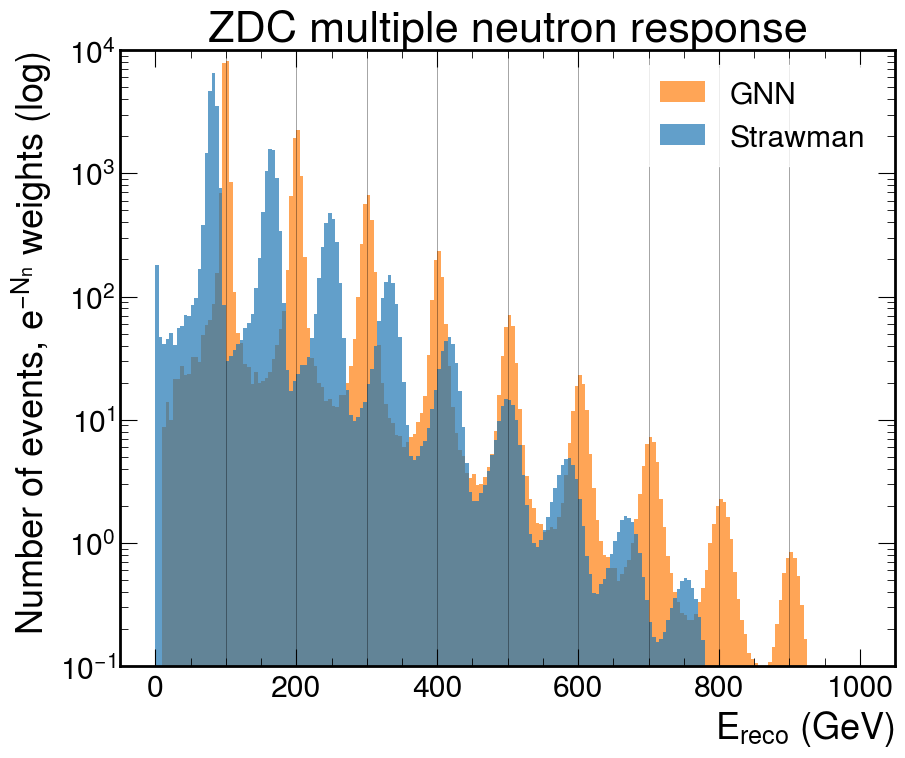

In [11]:
if multiple_neutrons:
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['savefig.bbox']='tight'
    plt.rcParams['legend.frameon']=True
    plt.rcParams['legend.edgecolor']='white'
    plt.rcParams["figure.figsize"] = (10, 8)

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # Only looking at 9 neutrons or less
    ml_energy_mask = np.round(targets_ene).astype(int) < 1000
    ml_num_neutrons = np.round(targets_ene).astype(int)/100

    strawman_np_energies = np.asarray(ak.flatten(strawman_true_energies))
    strawman_energy_mask = np.round(strawman_np_energies).astype(int) < 1000
    strawman_num_neutrons = np.round(strawman_np_energies).astype(int)/100

    fig = plt.figure()
    plt.hist(predictions_ene[ml_energy_mask],
             200,
             range=[0, 1000],
             alpha = 0.7,
             label="GNN",
             weights=np.exp(-1*ml_num_neutrons)[ml_energy_mask],
             color=colors[1],
             histtype='stepfilled'
            )
    plt.hist(ak.flatten(strawman_reco_energies)[strawman_energy_mask],
             200,
             range=[0, 1000],
             alpha = 0.7,
             label="Strawman",
             weights=np.exp(-1*strawman_num_neutrons)[strawman_energy_mask],
             color=colors[0],
             histtype='stepfilled'
            )


    plt.xlabel("$E_{reco}~(GeV)$")
    plt.ylabel("Number of events, $e^{-N_{n}}$ weights (log)")
    for energy in energy_bins[energy_bins<1000]:
        plt.axvline(x = energy, color = 'black', linestyle='solid', alpha = .5, linewidth = 0.5)
    plt.legend()
    plt.yscale('log')
    plt.ylim(10**(-1),10**(4))
    plt.title("ZDC multiple neutron response")
    if save_plots:
        output_pdf = PdfPages('/home/ryan/ml_analysis/zdc_multipleneutron_spectra_exponential.pdf')
        output_pdf.savefig(fig)
        output_pdf.close()

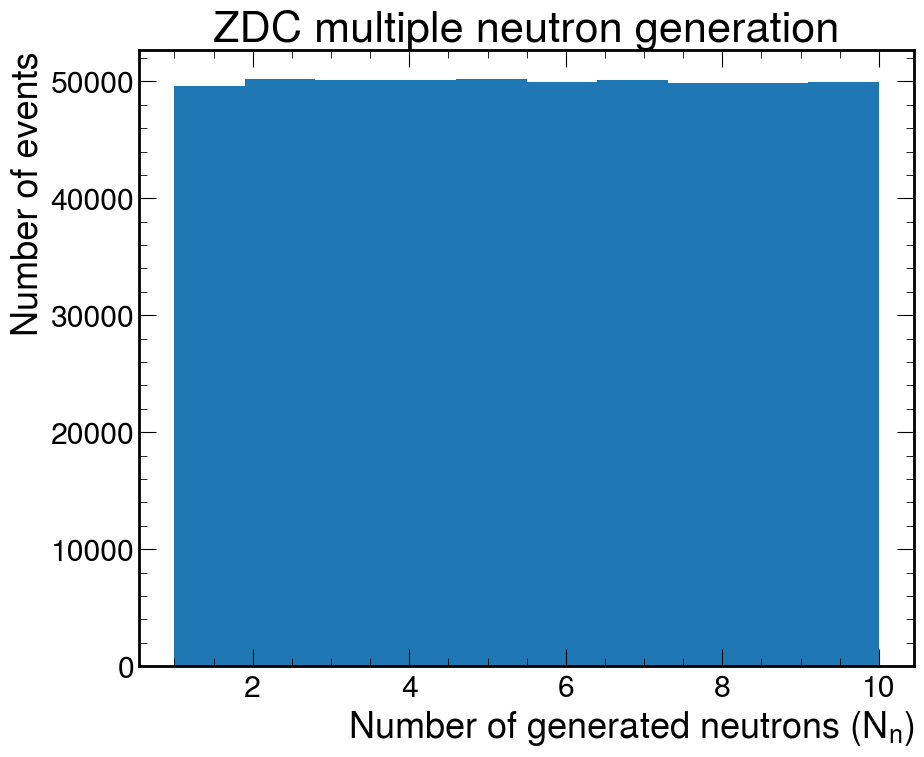

In [12]:
if multiple_neutrons:
    plt.rcParams['figure.facecolor']='white'
    plt.rcParams['savefig.facecolor']='white'
    plt.rcParams['savefig.bbox']='tight'
    plt.rcParams['legend.frameon']=True
    plt.rcParams['legend.edgecolor']='white'
    plt.rcParams["figure.figsize"] = (10, 8)
    fig = plt.figure()
    plt.hist(ak.flatten(strawman_true_energies)/100)
    plt.xlabel("Number of generated neutrons ($N_{n}$)")
    plt.ylabel("Number of events")
    plt.title("ZDC multiple neutron generation")
    if save_plots:
        output_pdf = PdfPages('/home/ryan/ml_analysis/zdc_num_neutrons.pdf')
        output_pdf.savefig(fig)
        output_pdf.close()

Total Sum:  81.03728862035841
-31      32     -32     32      3582        3739
Total Sum:  164.6960349310012
-31      32     -32     32      3582        3739
Total Sum:  325.9659721737816
-31      32     -32     32      3582        3739
Total Sum:  738.3782523018973
-31      32     -32     32      3582        3739


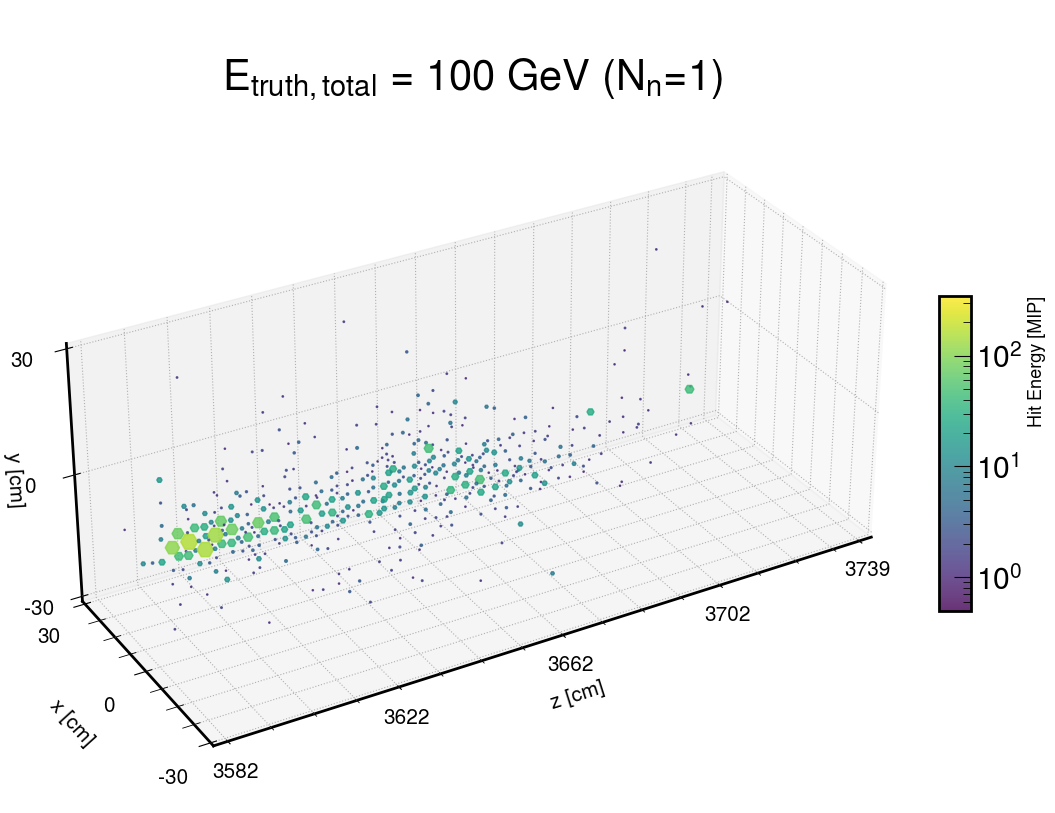

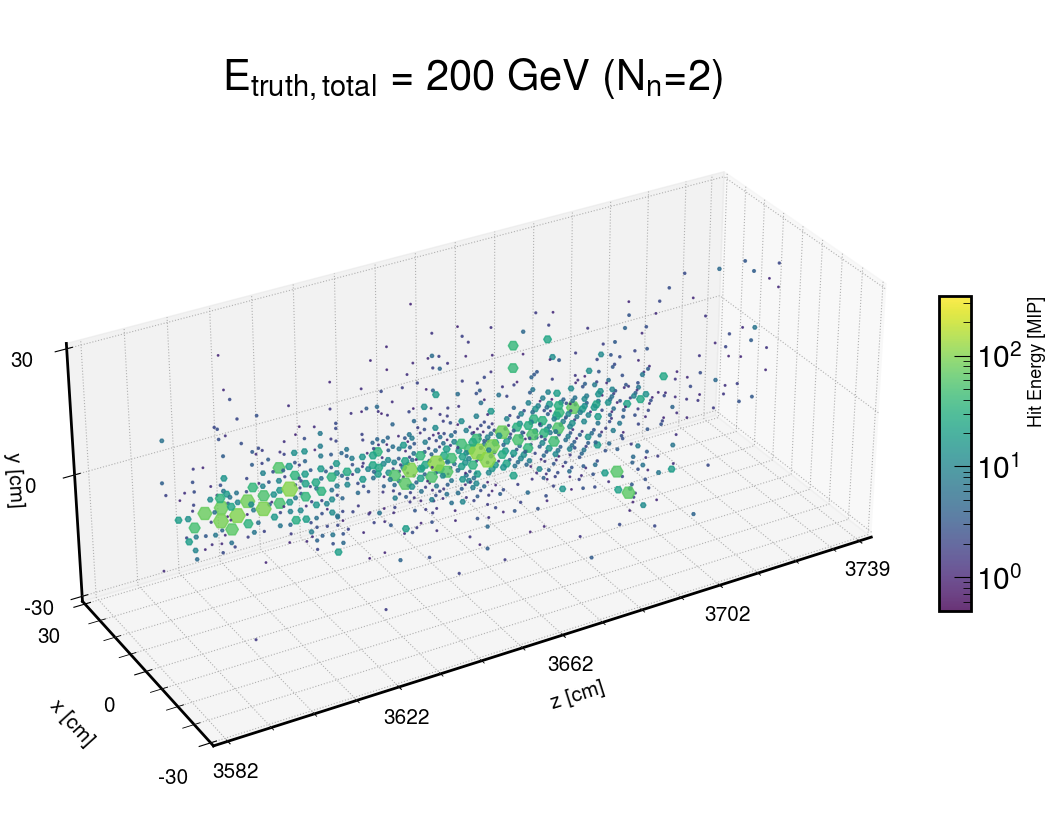

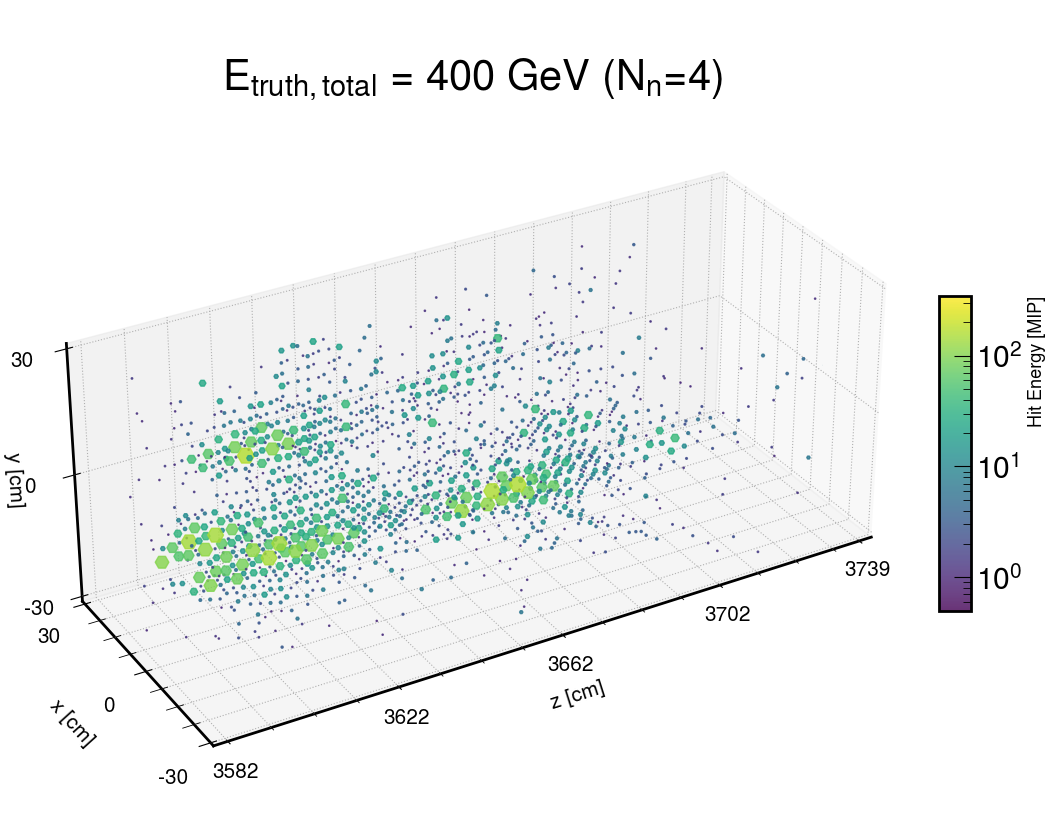

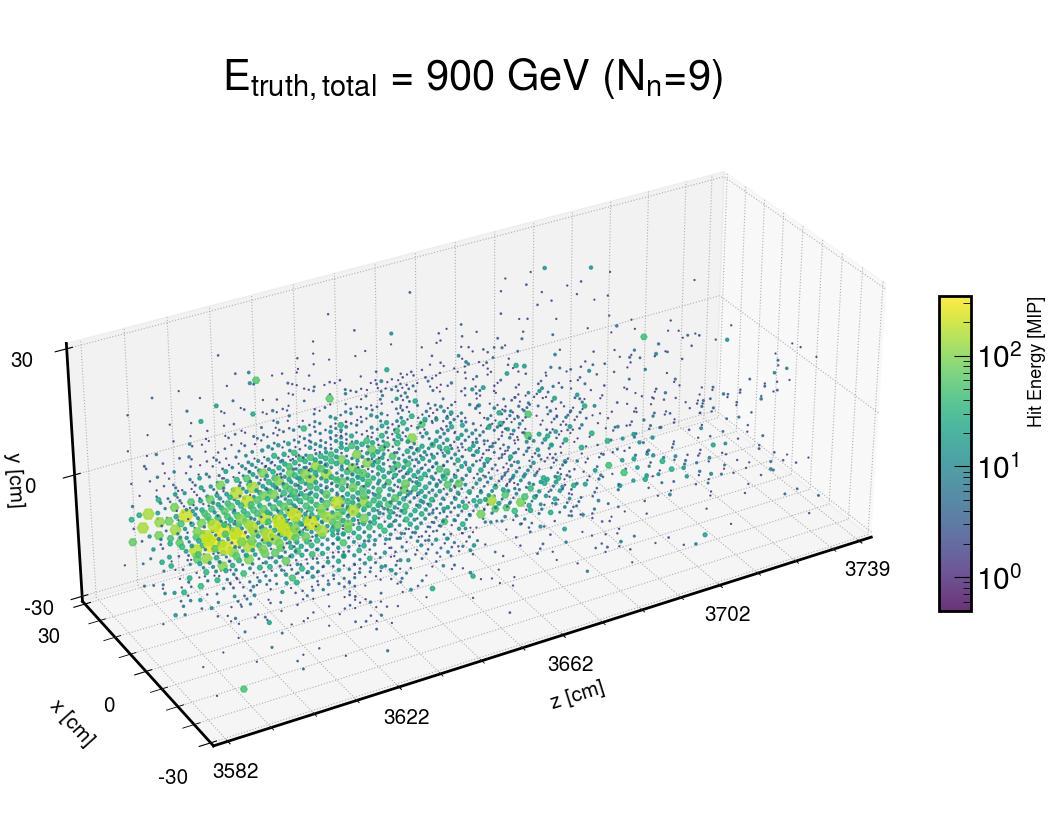

In [13]:
if multiple_neutrons:
    %matplotlib inline
    import uproot as ur
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
    import mplhep as hep
    import sys  

    hep.style.use("CMS")
    MIP= 0.000472

    def get_XYZ_dim(posx, posy, posz):
        x_min=int(np.min(ak.flatten(posx)))
        x_max=int (np.max(ak.flatten(posx)))

        y_min=int(np.min(ak.flatten(posy)))
        y_max=int(np.max(ak.flatten(posy)))

        z_min=int(np.min(ak.flatten(posz)))
        z_max=int(np.max(ak.flatten(posz)))
        
        return x_min, x_max, y_min, y_max, z_min, z_max
    def draw_event(fig, input_file, event, detector):
        scale_canvas=0.9

        if detector=="hcal":
            detector_name = "HcalEndcapPHitsReco"
            MIP_TH=0.5 * 0.0006
            Time_TH=150
            theta_max=600.0
            sampling_fraction=0.0224
        elif detector=='ecal':
            detector_name = "EcalEndcapPHitsReco"
            MIP_TH=0.5 * 0.13
            Time_TH=150
            theta_max=600.0
            sampling_fraction=1.0

        elif detector=="insert":
            detector_name= "HcalEndcapPInsertHitsReco"
            MIP_TH=0.5 * 0.0006
            Time_TH=150.0
            theta_max=600.0
            sampling_fraction=0.0224

        elif detector=="zdc":
            detector_name="ZDCHcalHitsReco"
            MIP_TH=0.5 * .000472
            Time_TH=275.0
            theta_max=10.0
            sampling_fraction=0.021

        else:
            print("Please make sure you have picked right detector name")     
            print("Pick: hcal or hcal_insert for endcap calo/ hcal_insert for insert")


        my_cmap = plt.get_cmap('viridis')

        events = ur.open(f'{input_file}:events')
        num_entries = events.num_entries
        arrays_sim = events.arrays()
        E=arrays_sim[f'{detector_name}.energy'][event,:]
        nhits=len(E)

        x=arrays_sim[f'{detector_name}.position.x'][event,:]/10.
        y=arrays_sim[f'{detector_name}.position.y'][event,:]/10.
        z=arrays_sim[f'{detector_name}.position.z'][event,:]/10.

        incident_mask = arrays_sim["MCParticles.generatorStatus"]==1
        num_particles = len(arrays_sim["MCParticles.PDG"][incident_mask][event])
        genPx = arrays_sim['MCParticles.momentum.x'][incident_mask][event]
        genPy = arrays_sim['MCParticles.momentum.y'][incident_mask][event]
        genPz = arrays_sim['MCParticles.momentum.z'][incident_mask][event]
        mom=np.sqrt(genPx*genPx + genPy*genPy + genPz*genPz)
        if num_particles > 1:
            total_mom = ak.sum(mom)
        elif num_particles == 1:
            total_mom = mom[0]
        theta=np.arccos(genPz/mom)*1000  #    *180/np.pi
        total_mom=round(total_mom, 2)
        total_mom = int(total_mom)

        slc=E>MIP
        
        ax1 = fig.add_subplot(211, projection='3d',azim=-120, elev=30)
        
        sctt3d = ax1.scatter3D(z[slc], x[slc], y[slc],
                        alpha = 0.8,
                        c = E[slc]/MIP,
                        s=150*E[slc]/np.max(E[slc]),
                        cmap = my_cmap,
                        norm=mpl.colors.LogNorm(),
                        marker ='H')


        print('Total Sum: ',ak.sum(E[slc]) /sampling_fraction)
        sctt3d.set_clim(vmin=0.5, vmax=350)
        cbar = fig.colorbar(sctt3d, shrink=0.45, pad=0.05, aspect=10)
        cbar.set_label('Hit Energy [MIP]', fontsize=13)


        x_min, x_max, y_min, y_max, z_min, z_max=get_XYZ_dim(arrays_sim[f'{detector_name}.position.x']/10.,\
                                                            arrays_sim[f'{detector_name}.position.y']/10.,\
                                                            arrays_sim[f'{detector_name}.position.z']/10.)
        print(x_min, '    ', x_max, '   ', y_min, '   ', y_max, '    ', z_min, '      ', z_max)
        max_val_for_plot=round(np.max([x_max, y_max])/10) *10

        plt.ylim(-max_val_for_plot,max_val_for_plot) #x
        plt.gca().set_zlim(-max_val_for_plot, max_val_for_plot) #y    
        z_ticks = np.arange(-max_val_for_plot, max_val_for_plot+1, max_val_for_plot)
        y_ticks = np.arange(-max_val_for_plot, max_val_for_plot+1, max_val_for_plot)

        ax1.set_zticks(z_ticks)
        ax1.set_yticks(y_ticks)
        specific_values = np.array([z_min, z_max])
        x_ticks = np.arange(z_min, z_max, 40)

        # Concatenate the specific values with the generated array
        x_ticks = np.append(x_ticks, [z_max])
        ax1.set_xticks(x_ticks)

        plt.gca().zaxis.labelpad = -2
        num_neutrons = ak.count(mom)
        ax1.set_title(f" \n$E_{{truth,total}}$ = {total_mom} GeV ($N_{{n}}$={num_neutrons})", fontsize=30, pad=-500)
        plt.gca().set_xlabel("\n\nz [cm]", fontsize=15)
        plt.gca().set_ylabel("\nx [cm]", fontsize=15)
        plt.gca().set_zlabel("y [cm]", fontsize=15)
        plt.gca().set_xlim(z_min, z_max)
        
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.gca().zaxis.set_tick_params(labelsize=15)

        plt.gca().set_box_aspect((180,70,70), zoom=1.2)
        return ax1

    
    file_path='/media/miguel/Elements/zdc_data/zdc_neutron_1to10_fixed_100GeV-100GeV_0.0deg-0.23deg_staggered_h4_04_22_2024/reco_neutron_fixed_100GeV-100GeV_theta_0.0deg-0.23deg_1-10particles_1859285_0.edm4hep.root'
    detector='zdc'
    fig_1_neutron=plt.figure( figsize=(30,20))
    ax2=draw_event(fig_1_neutron, file_path, 8, detector)
    if save_plots:
        output_pdf = PdfPages('/home/ryan/ml_analysis/zdc_1neutron_shower.pdf')
        output_pdf.savefig(fig_1_neutron)
        output_pdf.close()
    
    fig_2_neutron=plt.figure( figsize=(30,20))
    ax2=draw_event(fig_2_neutron, file_path, 29, detector)
    if save_plots:
        output_pdf = PdfPages('/home/ryan/ml_analysis/zdc_2neutron_shower.pdf')
        output_pdf.savefig(fig_2_neutron)
        output_pdf.close()
    
    fig_4_neutrons=plt.figure( figsize=(30,20))
    ax2=draw_event(fig_4_neutrons, file_path, 16, detector)
    if save_plots:
        output_pdf = PdfPages('/home/ryan/ml_analysis/zdc_4neutron_shower.pdf')
        output_pdf.savefig(fig_4_neutrons)
        output_pdf.close()

    fig_9_neutrons=plt.figure( figsize=(30,20))
    draw_event(fig_9_neutrons, file_path, 20, detector)
    if save_plots:
        output_pdf = PdfPages('/home/ryan/ml_analysis/zdc_9neutron_shower.pdf')
        output_pdf.savefig(fig_9_neutrons)
        output_pdf.close()

# Print the output and later use to plot

In [14]:
if model=='graphnet':
    approach='gnn_'
elif model=='DeepSets':
    approach='ds_'

particle_detector=f'Input{input_features}_output{output_dim}_{detector}_{absorber}'
name_tag=f'ds_{output_dim}D_output_'
particle='pp'

true_fit=np.round(true_fit, 2)    
print('##------------Energy REGRESSION PARAMETERS---------------------------------------')
print(f'##--Detector = {detector},   Absorber ={absorber },  input = {input_features},  output = {output_dim},\
     Model={model},  ECAL Status={include_ecal}')
print_parameter(true_fit, approach +'energy',particle_detector ) 
print_parameter(resolution_fit, approach +'res_fit', particle_detector ) ## sigma over mean fit 
print_parameter( pred_over_truth_fit, approach +'scale_median', particle_detector )



if output_dim=='2D':
    print('##------------THETA REGRESSION PARAMETERS---------------------------------------')
    print(f'##--Detector = {detector},   Absorber ={absorber },  input = {input_features},  output = {output_dim},\
     Model={model},  ECAL Status={include_ecal}')
    particle_detector=f'Input{input_features}_output{output_dim}_{detector}_{absorber}'
    name_tag=f'ds_{output_dim}D_output_'
    particle='pp'

    true_fit=np.round(true_fit, 2)    
    print_parameter(true_fit_th, approach +'energy',particle_detector ) 
    print_parameter(resolution_fit_th, approach +'theta_res_fit', particle_detector ) ## sigma over mean fit 


##------------Energy REGRESSION PARAMETERS---------------------------------------
##--Detector = zdc,   Absorber =64Fe,  input = 4D,  output = 1D,     Model=graphnet,  ECAL Status=False
gnn_energy_Input4D_output1D_zdc_64Fe=np. array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000.])
gnn_res_fit_Input4D_output1D_zdc_64Fe=np. array([0.026688, 0.024591, 0.021522, 0.01663 , 0.016267, 0.015295,
       0.01521 , 0.015748, 0.013009, 0.009189])
gnn_scale_median_Input4D_output1D_zdc_64Fe=np. array([1.000633, 1.003553, 1.00409 , 1.003166, 1.004377, 1.00397 ,
       1.003468, 1.003408, 1.002242, 0.999304])


In [15]:
##------------Energy REGRESSION PARAMETERS---------------------------------------
##--Detector = zdc, particle = Neutron  Absorber =64Fe,  input = 4D,  output = 2D, readout = h4,
## Model=graphnet,  ECAL Status=False, Energy weight = 0.5, Theta weight = 0.5

neutron_gnn_energy_Input4D_output2D_zdc_64Fe_energy5_theta5=np. array([ 10.,  11.,  12.,  13.,  14.,  16.,  17.,  19.,  21.,  24.,  26.,
        29.,  32.,  35.,  39.,  43.,  47.,  52.,  57.,  63.,  70.,  77.,
        85.,  93., 103., 114., 125., 138., 152., 168., 185., 204., 225.,
       248., 274., 302.])
neutron_gnn_res_fit_Input4D_output2D_zdc_64Fe_energy5_theta5=np. array([0.033208, 0.057008, 0.078576, 0.081658, 0.081465, 0.075656,
       0.074346, 0.070373, 0.067019, 0.063532, 0.060078, 0.05729 ,
       0.055018, 0.052475, 0.049437, 0.047814, 0.045971, 0.04398 ,
       0.042067, 0.040842, 0.037897, 0.037075, 0.035107, 0.034618,
       0.032765, 0.031672, 0.030248, 0.028915, 0.028348, 0.027182,
       0.026241, 0.025025, 0.024054, 0.022771, 0.021963, 0.020782])


In [16]:
##------------Theta REGRESSION PARAMETERS---------------------------------------
##--Detector = zdc, particle = Neutron  Absorber =64Fe,  input = 4D,  output = 2D, readout = h4,
## Model=graphnet,  ECAL Status=False, Energy weight = 0.5, Theta weight = 0.5

neutron_gnn_thetares_fit_Input4D_output2D_zdc_64Fe_energy5_theta5=np. array([0.20402 , 0.196213, 0.189261, 0.181842, 0.176967, 0.159359,
       0.15339 , 0.141767, 0.132393, 0.131955, 0.12275 , 0.114508,
       0.107211, 0.102532, 0.098484, 0.091446, 0.089304, 0.085634,
       0.081101, 0.076227, 0.07267 , 0.069081, 0.064609, 0.064571,
       0.06146 , 0.058149, 0.054894, 0.053096, 0.050096, 0.047076,
       0.047515, 0.045223, 0.043249, 0.040519, 0.041694, 0.038457])

In [17]:
## scales
neutron_gnn_energyscale_Input4D_output2D_zdc_64Fe_energy5_theta5=np.array([1.066476, 1.014272, 1.001467, 0.998677, 0.99897 , 0.997028,
       0.996481, 0.998298, 0.999849, 0.999725, 1.000828, 1.00021 ,
       1.00035 , 0.99965 , 1.000056, 1.000546, 1.000105, 1.001124,
       1.000918, 1.000577, 0.999898, 1.000218, 1.000614, 0.999518,
       1.000704, 1.000378, 1.001424, 1.000641, 1.000992, 1.001212,
       1.001521, 1.001694, 1.00122 , 1.000025, 0.99762 , 0.993033])

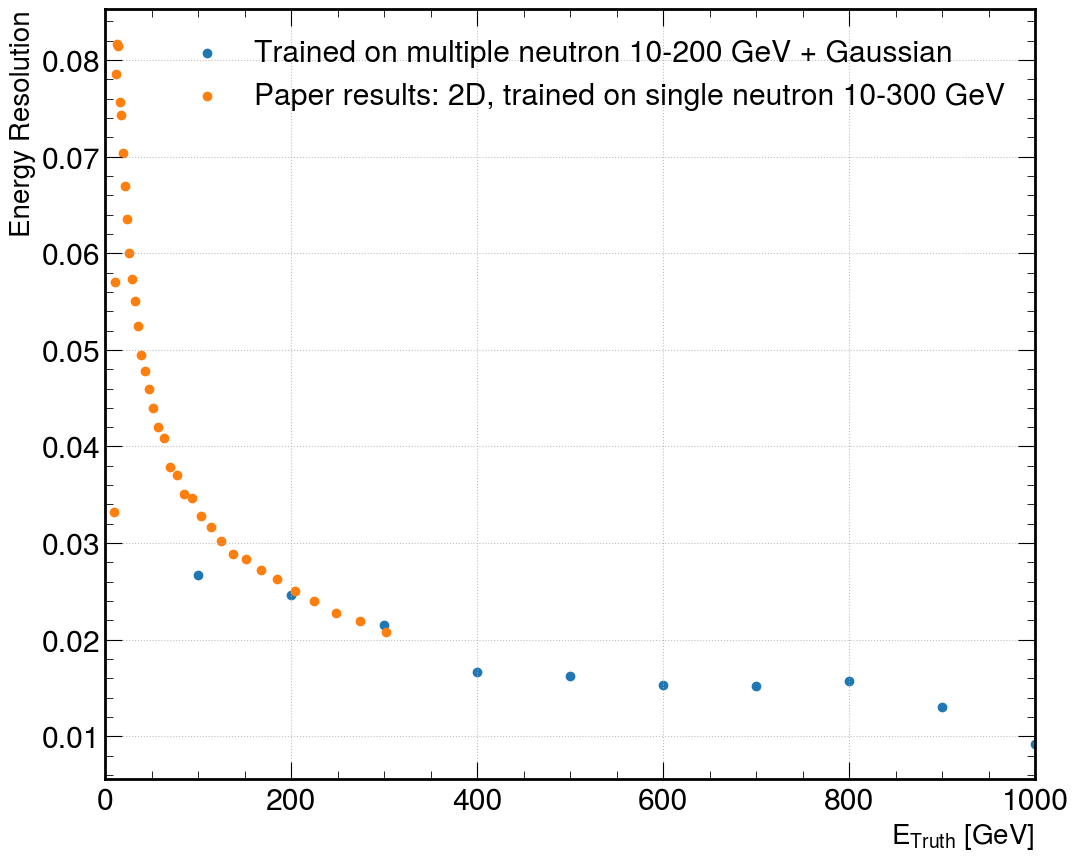

In [18]:
if output_dim=="2D":
    fig = plt.figure(figsize=(12,14))
    fig.set_facecolor('w')
    gs = fig.add_gridspec(2, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(
                    true_fit,
                    resolution_fit
                    )

    axs[1].scatter(
                    true_fit,
                    resolution_fit_th
                    )

    plt.xlabel('$E_{Truth}$ [GeV]', fontsize=20)
    axs[0].set_ylabel('Energy Resolution [%]',  fontsize=20)
    axs[1].set_ylabel('Angular Resolution [mrad]',  fontsize=20)
    axs[0].legend(fontsize="20")
    axs[1].legend(fontsize="20")
    axs[0].grid()
    axs[1].grid()

    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].set_xlim(0,300)
    axs[1].set_xlim(0,300)
else:
    fig = plt.figure(figsize=(12,10))
    fig.set_facecolor('w')
    plt.scatter(
             true_fit,
             resolution_fit,
             label="Trained on multiple neutron 10-200 GeV + Gaussian"
            )
    plt.scatter(
             neutron_gnn_energy_Input4D_output2D_zdc_64Fe_energy5_theta5,
             neutron_gnn_res_fit_Input4D_output2D_zdc_64Fe_energy5_theta5,
             label="Paper results: 2D, trained on single neutron 10-300 GeV"
            )
    plt.xlabel('$E_{Truth}$ [GeV]', fontsize=20)
    plt.ylabel('Energy Resolution',  fontsize=20)
#     plt.xscale('log')
    plt.xlim(0, 1000)
    plt.grid()
    plt.legend()

/tmp/ipykernel_3767157/216517089.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 1000)


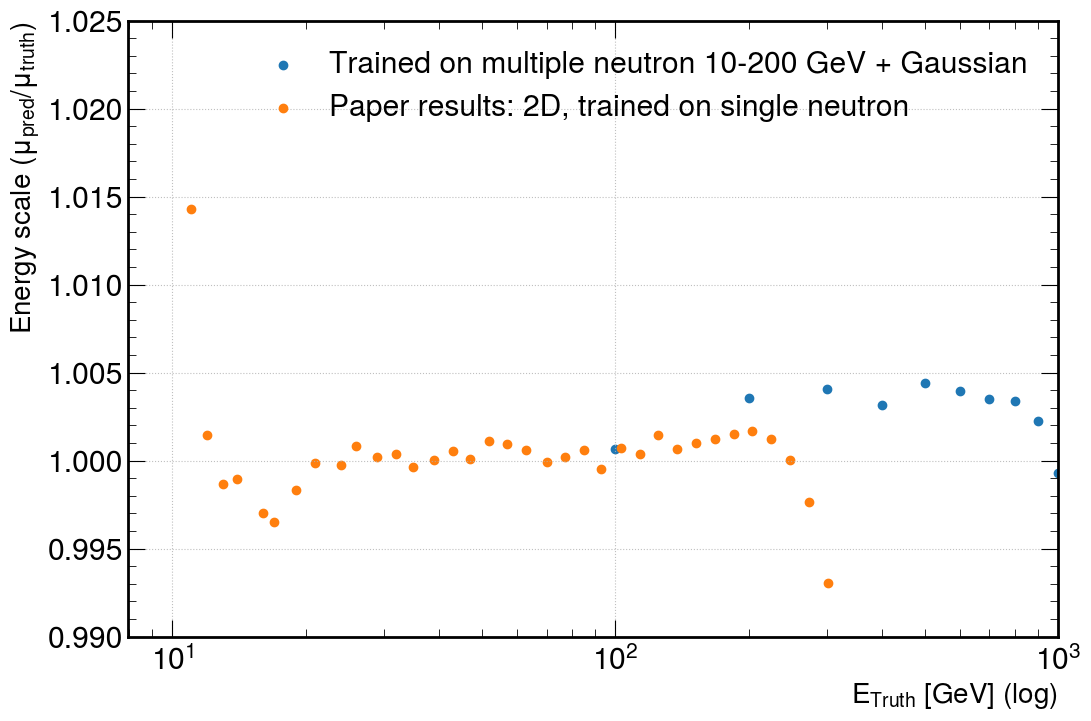

In [19]:
fig = plt.figure(figsize=(12,8))
fig.set_facecolor('w')
plt.scatter(
         true_fit,
         pred_over_truth_fit,
         label="Trained on multiple neutron 10-200 GeV + Gaussian"
        )
plt.scatter(
             neutron_gnn_energy_Input4D_output2D_zdc_64Fe_energy5_theta5,
             neutron_gnn_energyscale_Input4D_output2D_zdc_64Fe_energy5_theta5,
             label="Paper results: 2D, trained on single neutron"
            )
plt.xlabel('$E_{Truth}$ [GeV] (log)', fontsize=20)
plt.ylabel('Energy scale ($\mu_{pred}/\mu_{truth}$)',  fontsize=20)
plt.grid()
plt.xscale('log')
plt.xlim(0, 1000)
plt.ylim(.99,1.025)
plt.legend()